In [8]:
# Predicting potential alliance shifts in a world war using graph balance theory
# Heron Ziegel
# 915986142

import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import math

In [3]:
pip install ipynb

  Obtaining dependency information for ipynb from https://files.pythonhosted.org/packages/31/42/4c0bbb66390e3a68e04ebf134c8d074a00c18b5882293f8ace5f7497fbf0/ipynb-0.5.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [9]:
import ipynb.fs.full.utility_functions as util
import ipynb.fs.full.visualize_graph as vis

In [10]:
# UPDATE THESE VARIABLES TO CHANGE THE DATA & APPEARANCE

# Path where the data is stored
DATA_FILEPATH = '../Data/Starting/'

# WW1, WW2, countries
CSV_FILE = 'WW2.csv'

# integer 1-6, changes how the graph visuals appear
SEED = 6 

In [11]:
# Grab data from CSV adjacency matrix

df = pd.read_csv(DATA_FILEPATH + CSV_FILE, index_col=0)

input_data = df.to_numpy()
column_names = df.columns

G = util.newGraph(input_data, column_names)

print(G)

Graph with 6 nodes and 9 edges


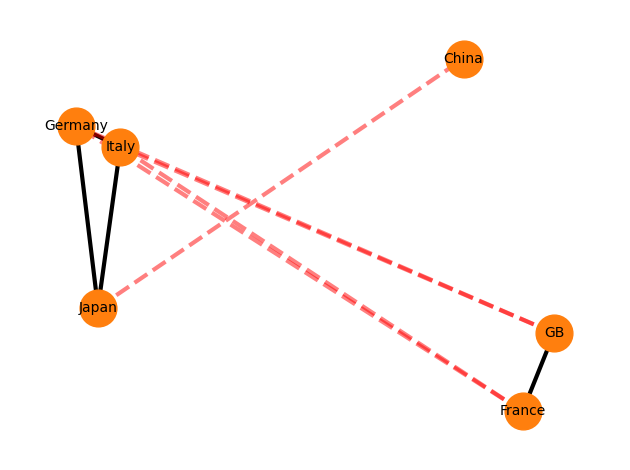

In [12]:
# Visualize initial graph

vis.showGraph(G, SEED, column_names)

print("Structural balance: ", util.structural_balance(G))

In [13]:
# Partitioning

# Use Louvain Algorithm for initial partitions
# Must make a copy of the graph without negative edges to focus on positive edge based partition
to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] == -1]
G1 = G.copy()
G1.remove_edges_from(to_remove)

initial_partitions = nx.community.louvain_communities(G1, seed=123)
# Sort by length of partition, largest to smallest
initial_partitions.sort(key=len, reverse=True)
print(initial_partitions)

# Calculate the number of possible 2-way split permutations after the initial Louvain algorithm is run
permutations = int(math.factorial(len(initial_partitions)) / (math.factorial(len(initial_partitions)//2) * (len(initial_partitions) - math.factorial(len(initial_partitions)//2))))
print("Number of partition permutations: ", permutations)

# Arbitrarily create two roughly even sides
side1 = []
side2 = []

for i in range(len(initial_partitions)):
    if len(side1) <= len(side2):
        for j in initial_partitions[i]:
            side1.append(j)
    else:
        for k in initial_partitions[i]:
            side2.append(k)

print("sides")
print(side1)
print(side2)

[{'Germany', 'Italy', 'Japan'}, {'France', 'GB'}, {'China'}]
Number of partition permutations:  3
sides
['Germany', 'Italy', 'Japan']
['France', 'GB', 'China']


In [15]:
# Balancing

# Iterate through unbalanced triads, if negative edge exists within same partition side change to positive
triangle_types = util.triangles(G)

for tri in triangle_types:
    # If the triad is unbalanced, update so that it is balanced
    if triangle_types[tri] == -1:
        # Iterate through 3 countries within triangle
        for a in tri:
            for b in tri:
                # Update negative edge to positive edge if they are in the same partition side
                if a != b and ((a in side1 and b in side1) or (a in side2 and b in side2)):
                    update_edge_weight(a,b,1)
                    triangles()

# ADD MORE LOGIC HERE TO ADDRESS CHANGES IN SIDES
# Minimize negative edges within each partition by swapping subgraphs?

In [17]:
# Just for visual effect at the end, not part of core logic

# Fill in missing edges within partition as positive
for c_a in side1:
    for c_b in side1:
        if c_a != c_b:
            util.update_edge_weight(G,c_a,c_b,1)

for c1_a in side2:
    for c1_b in side2:
        if c1_a != c1_b:
            util.update_edge_weight(G,c1_a,c1_b,1)

# Fill in missing edges outside of partition as negative
for c_side1 in side1:
    for c_side2 in side2:
        util.update_edge_weight(G,c_side1,c_side2,-1)
        
print(util.triangles(G))

{('Germany', 'Japan', 'China'): 1, ('Italy', 'Japan', 'China'): 1, ('France', 'Japan', 'China'): 1, ('GB', 'Japan', 'China'): 1, ('Germany', 'Italy', 'China'): 1, ('France', 'Italy', 'China'): 1, ('GB', 'Italy', 'China'): 1, ('France', 'Germany', 'China'): 1, ('GB', 'Germany', 'China'): 1, ('GB', 'France', 'China'): 1}


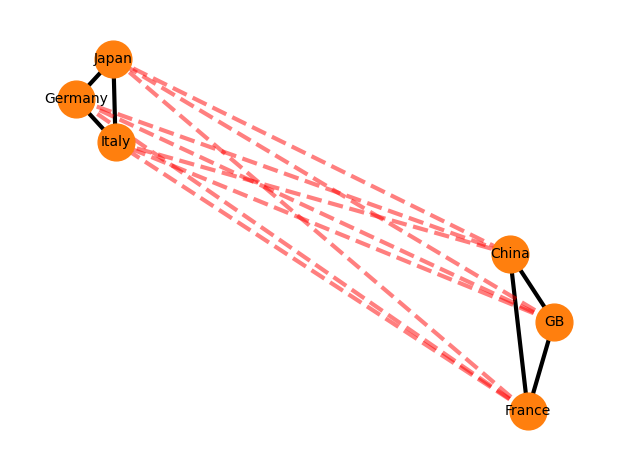

Structural balance:  0.5


In [19]:
# Final Visualization

vis.showGraph(G, SEED, column_names)

print("Structural balance: ", util.structural_balance(G))